# 필요한 모듈 임포트

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 선수가치만 스크래핑

## 컬럼명 가져오기

In [2]:
url = 'https://www.transfermarkt.com/spieler-statistik/wertvollstespieler/marktwertetop'

# google에 my user agent 검색해서 알아볼 수 있다.
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/125.0.0.0 Safari/537.36'}

page = requests.get(url, headers=headers) # header속성을 줘야 접근 가능한 사이트가 있다.
# print(page) # 200이 되어야 한다.

soup = BeautifulSoup(page.text, 'html.parser')

columns = []
thead = soup.find('thead')
for th_tag in thead.th.next_siblings:
    columns.append(th_tag.text)
columns

['Player', 'Age', 'Nat.', 'Club', 'Market value']

## 행 데이터 가져오기

In [3]:
row_data = []

for i in range(1,5):
    url = f'https://www.transfermarkt.com/spieler-statistik/wertvollstespieler/marktwertetop?page={i}'

    page = requests.get(url, headers=headers)
    
    soup = BeautifulSoup(page.text, 'html.parser')
    
    tbody = soup.select('tbody')[1]
    tr_tags = tbody.find_all('tr', ['odd', 'even']) 
    
    for tr_tag in tr_tags:
        td_tags = tr_tag.td.next_siblings # 처음 인덱스는 제외하고 나옴 (next이므로)
        
        row = []
        for i, td_tag in enumerate(td_tags):
            if i == 0:
                name = td_tag.find_all('a')[1].text      # 이름
                position = td_tag.find_all('td')[2].text # 포지션
                row.append([name, position])
            elif i == 1:
                age = td_tag.text                        # 나이
                row.append(age)
            elif i == 2:
                img_tags = td_tag.find_all('img')
                nation_lst = []
                for img_tag in img_tags:
                    nation_lst.append(img_tag['title'])  #국적
                # nations = ",".join(nation_lst)
                # row.append(nations)
                row.append(nation_lst)
            elif i == 3:
                a_tag = td_tag.find('a')
                team = a_tag['title']                    # 팀
                row.append(team)
            else:
                a_tag = td_tag.find('a')
                value = a_tag.text                       # 선수 가치
                row.append(value)
                
        row_data.append(row)

row_data

[[['Jude Bellingham', 'Attacking Midfield'],
  '20',
  ['England', 'Ireland'],
  'Real Madrid',
  '€180.00m'],
 [['Erling Haaland', 'Centre-Forward'],
  '23',
  ['Norway'],
  'Manchester City',
  '€180.00m'],
 [['Vinicius Junior', 'Left Winger'],
  '23',
  ['Brazil', 'Spain'],
  'Real Madrid',
  '€180.00m'],
 [['Kylian Mbappé', 'Centre-Forward'],
  '25',
  ['France', 'Cameroon'],
  'Paris Saint-Germain',
  '€180.00m'],
 [['Phil Foden', 'Right Winger'],
  '24',
  ['England'],
  'Manchester City',
  '€150.00m'],
 [['Bukayo Saka', 'Right Winger'],
  '22',
  ['England', 'Nigeria'],
  'Arsenal FC',
  '€140.00m'],
 [['Florian Wirtz', 'Attacking Midfield'],
  '21',
  ['Germany'],
  'Bayer 04 Leverkusen',
  '€130.00m'],
 [['Jamal Musiala', 'Attacking Midfield'],
  '21',
  ['Germany', 'England'],
  'Bayern Munich',
  '€120.00m'],
 [['Federico Valverde', 'Central Midfield'],
  '25',
  ['Uruguay', 'Spain'],
  'Real Madrid',
  '€120.00m'],
 [['Declan Rice', 'Defensive Midfield'],
  '25',
  ['Engla

## 데이터 프레임 만들기

In [4]:
soccer_players = pd.DataFrame(data=row_data, columns=columns)
soccer_players

,Player,Age,Nat.,Club,Market value
0,"[Jude Bellingham, Attacking Midfield]",20,"[England, Ireland]",Real Madrid,€180.00m
1,"[Erling Haaland, Centre-Forward]",23,[Norway],Manchester City,€180.00m
2,"[Vinicius Junior, Left Winger]",23,"[Brazil, Spain]",Real Madrid,€180.00m
3,"[Kylian Mbappé, Centre-Forward]",25,"[France, Cameroon]",Paris Saint-Germain,€180.00m
4,"[Phil Foden, Right Winger]",24,[England],Manchester City,€150.00m
...,...,...,...,...,...
95,"[Conor Gallagher, Central Midfield]",24,[England],Chelsea FC,€50.00m
96,"[Vitinha, Central Midfield]",24,[Portugal],Paris Saint-Germain,€50.00m
97,"[Amadou Onana, Defensive Midfield]",22,"[Belgium, Senegal]",Everton FC,€50.00m
98,"[Jeremie Frimpong, Right Midfield]",23,"[Netherlands, Ghana]",Bayer 04 Leverkusen,€50.00m


In [5]:
# 중복된 값 없이 잘 스크래핑 된 것을 확인
len(soccer_players['Player'].apply(str).unique())

100

# numerical data 포함해서 스크래핑(자세한 데이터도 같이 스크래핑)

## 컬럼명 가져오기

In [6]:
url = "https://www.transfermarkt.com/spieler-statistik/wertvollstespieler/marktwertetop?land_id=0&ausrichtung=alle&spielerposition_id=alle&altersklasse=alle&jahrgang=0&kontinent_id=0&plus=1&page=1"

page = requests.get(url, headers=headers)

soup = BeautifulSoup(page.text, 'html.parser')

columns = []
thead = soup.find('thead')
for th_tag in thead.th.next_siblings:
    if th_tag.text: columns.append(th_tag.text)
    else: columns.append(th_tag.div['title'])
        
columns

['Player',
 'Age',
 'Nat.',
 'Club',
 'Market value',
 'Matches',
 'Goals',
 'Own goals',
 'Assists',
 'Yellow cards',
 'Second yellow card',
 'Red cards',
 'Substitutions on',
 'Substitutions off']

## 행 데이터 가져오기

In [7]:
def scrapping(soup):

    tbody = soup.select('tbody')[1]
    tr_tags = tbody.find_all('tr', ['odd', 'even']) 
    
    for tr_tag in tr_tags:
        td_tags = tr_tag.td.next_siblings # 처음 인덱스는 제외하고 나옴 (next이므로)
        
        row = []
        for i, td_tag in enumerate(td_tags):
            if i == 0:
                name = td_tag.find_all('a')[1].text      # 이름
                position = td_tag.find_all('td')[2].text # 포지션
                row.append([name, position])
            elif i == 1:
                age = td_tag.text                        # 나이
                row.append(age)
            elif i == 2:
                img_tags = td_tag.find_all('img')
                nation_lst = []
                for img_tag in img_tags:
                    nation_lst.append(img_tag['title'])  # 국적
                # nations = ",".join(nation_lst)
                # row.append(nations)
                row.append(nation_lst)
            elif i == 3:
                a_tag = td_tag.find('a')
                team = a_tag['title']                    # 팀
                row.append(team)
            elif i == 4:
                a_tag = td_tag.find('a')
                value = a_tag.text                       # 선수 가치
                row.append(value)
            else:
                row.append(td_tag.text)                  # 나머지 numerical data
                
        row_data.append(row)

In [8]:
row_data = []

for i in range(1, 5): # 페이지 수, 1페이지 당 25위 까지 있다.
    url = f"https://www.transfermarkt.com/spieler-statistik/wertvollstespieler/marktwertetop?land_id=0&ausrichtung=alle&spielerposition_id=alle&altersklasse=alle&jahrgang=0&kontinent_id=0&plus=1&page={i}"
    
    page = requests.get(url, headers=headers)
    soup = BeautifulSoup(page.text, 'html.parser')

    scrapping(soup)

row_data    

[[['Jude Bellingham', 'Attacking Midfield'],
  '20',
  ['England', 'Ireland'],
  'Real Madrid',
  '€180.00m',
  '46',
  '26',
  '0',
  '14',
  '11',
  '0',
  '1',
  '1',
  '18'],
 [['Erling Haaland', 'Centre-Forward'],
  '23',
  ['Norway'],
  'Manchester City',
  '€180.00m',
  '50',
  '42',
  '0',
  '6',
  '1',
  '0',
  '0',
  '3',
  '19'],
 [['Vinicius Junior', 'Left Winger'],
  '23',
  ['Brazil', 'Spain'],
  'Real Madrid',
  '€180.00m',
  '43',
  '24',
  '0',
  '12',
  '11',
  '0',
  '0',
  '5',
  '23'],
 [['Kylian Mbappé', 'Centre-Forward'],
  '25',
  ['France', 'Cameroon'],
  'Paris Saint-Germain',
  '€180.00m',
  '54',
  '46',
  '0',
  '15',
  '7',
  '0',
  '0',
  '6',
  '7'],
 [['Phil Foden', 'Right Winger'],
  '24',
  ['England'],
  'Manchester City',
  '€150.00m',
  '59',
  '28',
  '0',
  '12',
  '3',
  '0',
  '0',
  '6',
  '21'],
 [['Bukayo Saka', 'Right Winger'],
  '22',
  ['England', 'Nigeria'],
  'Arsenal FC',
  '€140.00m',
  '50',
  '20',
  '0',
  '15',
  '4',
  '0',
  '0'

In [9]:
soccer_players_detail = pd.DataFrame(data=row_data, columns=columns)
soccer_players_detail

,Player,Age,Nat.,Club,Market value,Matches,Goals,Own goals,Assists,Yellow cards,Second yellow card,Red cards,Substitutions on,Substitutions off
0,"[Jude Bellingham, Attacking Midfield]",20,"[England, Ireland]",Real Madrid,€180.00m,46,26,0,14,11,0,1,1,18
1,"[Erling Haaland, Centre-Forward]",23,[Norway],Manchester City,€180.00m,50,42,0,6,1,0,0,3,19
2,"[Vinicius Junior, Left Winger]",23,"[Brazil, Spain]",Real Madrid,€180.00m,43,24,0,12,11,0,0,5,23
3,"[Kylian Mbappé, Centre-Forward]",25,"[France, Cameroon]",Paris Saint-Germain,€180.00m,54,46,0,15,7,0,0,6,7
4,"[Phil Foden, Right Winger]",24,[England],Manchester City,€150.00m,59,28,0,12,3,0,0,6,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,"[Conor Gallagher, Central Midfield]",24,[England],Chelsea FC,€50.00m,55,7,0,9,9,1,0,6,11
96,"[Vitinha, Central Midfield]",24,[Portugal],Paris Saint-Germain,€50.00m,49,9,0,6,3,0,0,7,11
97,"[Amadou Onana, Defensive Midfield]",22,"[Belgium, Senegal]",Everton FC,€50.00m,42,3,0,2,5,0,0,8,11
98,"[Jeremie Frimpong, Right Midfield]",23,"[Netherlands, Ghana]",Bayer 04 Leverkusen,€50.00m,51,15,0,13,7,0,0,11,31


In [10]:
# 중복된 값 없이 잘 스크래핑 된 것을 확인
soccer_players_detail['Player'].describe()

count                                       100
unique                                      100
top       [Jude Bellingham, Attacking Midfield]
freq                                          1
Name: Player, dtype: object

## 아시아 선수들 scrapping

In [11]:
row_data = []
for i in range(1, 5): # 페이지 수, 1페이지 당 25위 까지 있다.
    url = f"https://www.transfermarkt.com/spieler-statistik/wertvollstespieler/marktwertetop?ajax=yw1&altersklasse=alle&ausrichtung=alle&jahrgang=0&kontinent_id=1&land_id=0&plus=1&spielerposition_id=alle&page={i}"
    
    page = requests.get(url, headers=headers)
    
    soup = BeautifulSoup(page.text, 'html.parser')

    scrapping(soup)
    
row_data

[[['Takefusa Kubo', 'Right Winger'],
  '23',
  ['Japan'],
  'Real Sociedad',
  '€50.00m',
  '46',
  '8',
  '0',
  '11',
  '4',
  '0',
  '0',
  '9',
  '19'],
 [['Kaoru Mitoma', 'Left Winger'],
  '27',
  ['Japan'],
  'Brighton & Hove Albion',
  '€45.00m',
  '27',
  '3',
  '0',
  '5',
  '6',
  '0',
  '0',
  '4',
  '7'],
 [['Min-jae Kim', 'Centre-Back'],
  '27',
  ['Korea, South'],
  'Bayern Munich',
  '€45.00m',
  '45',
  '2',
  '0',
  '3',
  '5',
  '0',
  '0',
  '7',
  '5'],
 [['Heung-min Son', 'Left Winger'],
  '31',
  ['Korea, South'],
  'Tottenham Hotspur',
  '€45.00m',
  '46',
  '25',
  '1',
  '12',
  '1',
  '0',
  '0',
  '3',
  '17'],
 [['Takehiro Tomiyasu', 'Right-Back'],
  '25',
  ['Japan'],
  'Arsenal FC',
  '€35.00m',
  '36',
  '2',
  '0',
  '3',
  '0',
  '1',
  '0',
  '15',
  '7'],
 [['Hiroki Ito', 'Centre-Back'],
  '25',
  ['Japan'],
  'VfB Stuttgart',
  '€30.00m',
  '35',
  '0',
  '0',
  '3',
  '3',
  '0',
  '0',
  '2',
  '5'],
 [['Kang-in Lee', 'Attacking Midfield'],
  '23',

In [12]:
asia_players = pd.DataFrame(data=row_data, columns=columns)
asia_players

,Player,Age,Nat.,Club,Market value,Matches,Goals,Own goals,Assists,Yellow cards,Second yellow card,Red cards,Substitutions on,Substitutions off
0,"[Takefusa Kubo, Right Winger]",23,[Japan],Real Sociedad,€50.00m,46,8,0,11,4,0,0,9,19
1,"[Kaoru Mitoma, Left Winger]",27,[Japan],Brighton & Hove Albion,€45.00m,27,3,0,5,6,0,0,4,7
2,"[Min-jae Kim, Centre-Back]",27,"[Korea, South]",Bayern Munich,€45.00m,45,2,0,3,5,0,0,7,5
3,"[Heung-min Son, Left Winger]",31,"[Korea, South]",Tottenham Hotspur,€45.00m,46,25,1,12,1,0,0,3,17
4,"[Takehiro Tomiyasu, Right-Back]",25,[Japan],Arsenal FC,€35.00m,36,2,0,3,0,1,0,15,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,"[Khalid Hashemi, Centre-Back]",27,[United Arab Emirates],Al-Ain FC,€2.00m,41,0,0,0,6,0,0,4,6
96,"[Majid Rashid, Defensive Midfield]",24,[United Arab Emirates],Sharjah FC,€2.00m,41,1,0,2,11,1,0,11,7
97,"[Sultan Al-Ghannam, Right-Back]",30,[Saudi Arabia],Al-Nassr FC,€2.00m,38,2,0,11,1,0,1,2,12
98,"[Daiki Hashioka, Right-Back]",25,[Japan],Luton Town,€2.00m,36,2,2,2,4,0,0,11,10


In [13]:
# 중복된 값 없는 것 확인
asia_players['Player'].describe()

count                               100
unique                              100
top       [Takefusa Kubo, Right Winger]
freq                                  1
Name: Player, dtype: object

## 엑셀파일에 두 데이터프레임 저장

In [14]:
# 엑셀 파일에 저장
with pd.ExcelWriter('soccer_players.xlsx') as writer:
    soccer_players_detail.to_excel(writer, sheet_name='world_soccer_players', index=False)
    asia_players.to_excel(writer, sheet_name='asia_soccer_players', index=False)

# 아시아 선수 Data Analysis

## 파일 읽어오기

In [3]:
asia_players_original = pd.read_excel('soccer_players.xlsx', sheet_name='asia_soccer_players')

In [27]:
asia_players = asia_players_original.copy()

In [28]:
asia_players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Player              100 non-null    object
 1   Age                 100 non-null    int64 
 2   Nat.                100 non-null    object
 3   Club                100 non-null    object
 4   Market value        100 non-null    object
 5   Matches             100 non-null    int64 
 6   Goals               100 non-null    int64 
 7   Own goals           100 non-null    int64 
 8   Assists             100 non-null    int64 
 9   Yellow cards        100 non-null    int64 
 10  Second yellow card  100 non-null    int64 
 11  Red cards           100 non-null    int64 
 12  Substitutions on    100 non-null    int64 
 13  Substitutions off   100 non-null    int64 
dtypes: int64(10), object(4)
memory usage: 11.1+ KB


## 데이터 전처리

In [29]:
# 이름과 포지션 분리하기
asia_players['player_name'] = asia_players['Player'].str.split(", ").str[0].str[2:-1]
asia_players['position'] = asia_players['Player'].str.split(", ").str[1].str[1:-2]

In [30]:
# 국적 str형식으로 바꾸기
asia_players['Nat.'] = asia_players['Nat.'].str[2:-2].str.replace("', '", ", ")
asia_players['Nat.'] = asia_players['Nat.'].str.replace("', \"", ", ")

In [31]:
asia_players['Nat.']

0                    Japan
1                    Japan
2             Korea, South
3             Korea, South
4                    Japan
              ...         
95    United Arab Emirates
96    United Arab Emirates
97            Saudi Arabia
98                   Japan
99                    Iran
Name: Nat., Length: 100, dtype: object

In [32]:
# 선수가치 컬럼 숫자형으로 타입 변경
asia_players['Market value(million EUR)'] = asia_players['Market value'].str[1:-1]
asia_players['Market value(million EUR)'] = asia_players['Market value(million EUR)'].astype(float)
asia_players['Market value(million EUR)'].dtype

dtype('float64')

In [33]:
# 숫자형으로 변환해야할 컬럼 변경
asia_players.columns
numerical_cols = ['Age', 'Matches', 'Goals', 'Own goals',
       'Assists', 'Yellow cards', 'Second yellow card', 'Red cards',
       'Substitutions on', 'Substitutions off']
asia_players[numerical_cols] = asia_players[numerical_cols].astype(int)

In [22]:
# 유로 한국 돈으로 환산
# asia_players['Market_value(million WON)'] = \
# asia_players['Market value(million EUR)'].apply(lambda x: x*1490.89) # 24년 6월5일 12:17 기준 환율, 환율 받아오는 함수도 있다.(upbit에서 가져오기 등)

In [23]:
asia_players['Market value(million EUR)'].unique()

array([50. , 45. , 35. , 30. , 25. , 20. , 18. , 15. , 14. , 13. , 12. ,
       10. ,  9. ,  8.5,  8. ,  7. ,  6. ,  5. ,  4.5,  4. ,  3.5,  3. ,
        2.5,  2.3,  2.2,  2. ])

## 선수가치 상위 10명

In [37]:
asia_players[['player_name', 'Age', 'Nat.', 'Club', 'position', 'Market value(million EUR)']].head(10)

,player_name,Age,Nat.,Club,position,Market value(million EUR)
0,Takefusa Kubo,23,Japan,Real Sociedad,Right Winger,50.0
1,Kaoru Mitoma,27,Japan,Brighton & Hove Albion,Left Winger,45.0
2,Min-jae Kim,27,"Korea, South",Bayern Munich,Centre-Back,45.0
3,Heung-min Son,31,"Korea, South",Tottenham Hotspur,Left Winger,45.0
4,Takehiro Tomiyasu,25,Japan,Arsenal FC,Right-Back,35.0
5,Hiroki Ito,25,Japan,VfB Stuttgart,Centre-Back,30.0
6,Kang-in Lee,23,"Korea, South",Paris Saint-Germain,Attacking Midfield,25.0
7,Hee-chan Hwang,28,"Korea, South",Wolverhampton Wanderers,Centre-Forward,25.0
8,Takumi Minamino,29,Japan,AS Monaco,Left Winger,20.0
9,Ritsu Doan,26,Japan,SC Freiburg,Right Winger,18.0


## 전체 선수 가치 분포

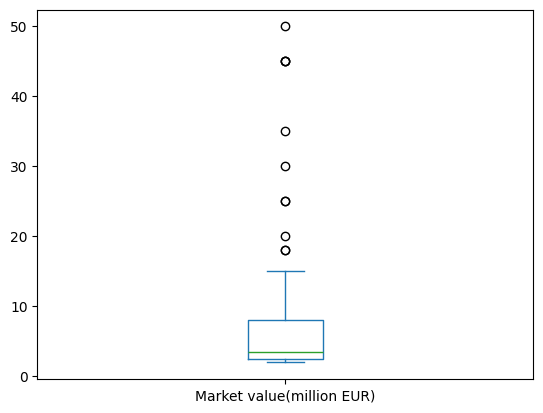

In [24]:
asia_players['Market value(million EUR)'].plot(kind='box')
plt.show()

## 포지션별 선수 가치 분포

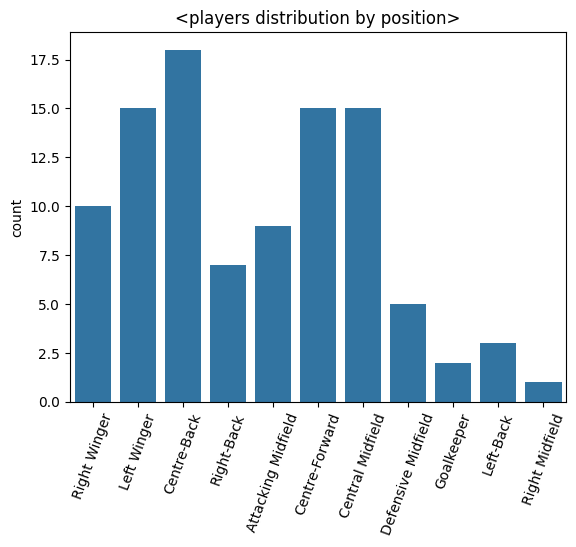

In [25]:
sns.countplot(data=asia_players, x='position')
plt.xticks(rotation=70)
plt.title("<players distribution by position>")
plt.xlabel("")
plt.show()

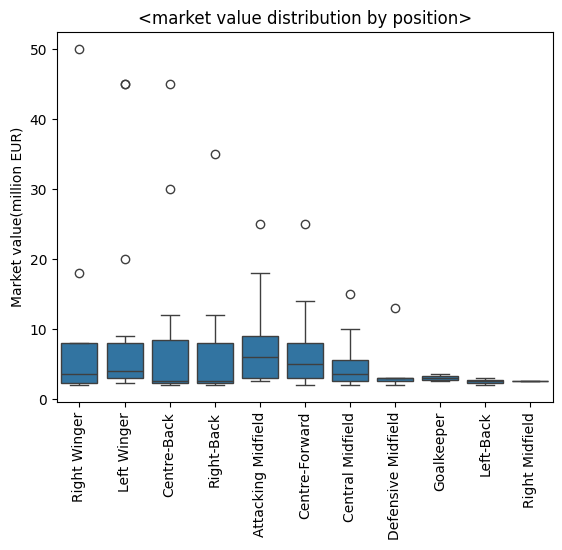

In [26]:
sns.boxplot(x=asia_players['position'], y=asia_players['Market value(million EUR)'])
plt.xticks(rotation=90)
plt.xlabel('')
plt.title('<market value distribution by position>')
plt.show()

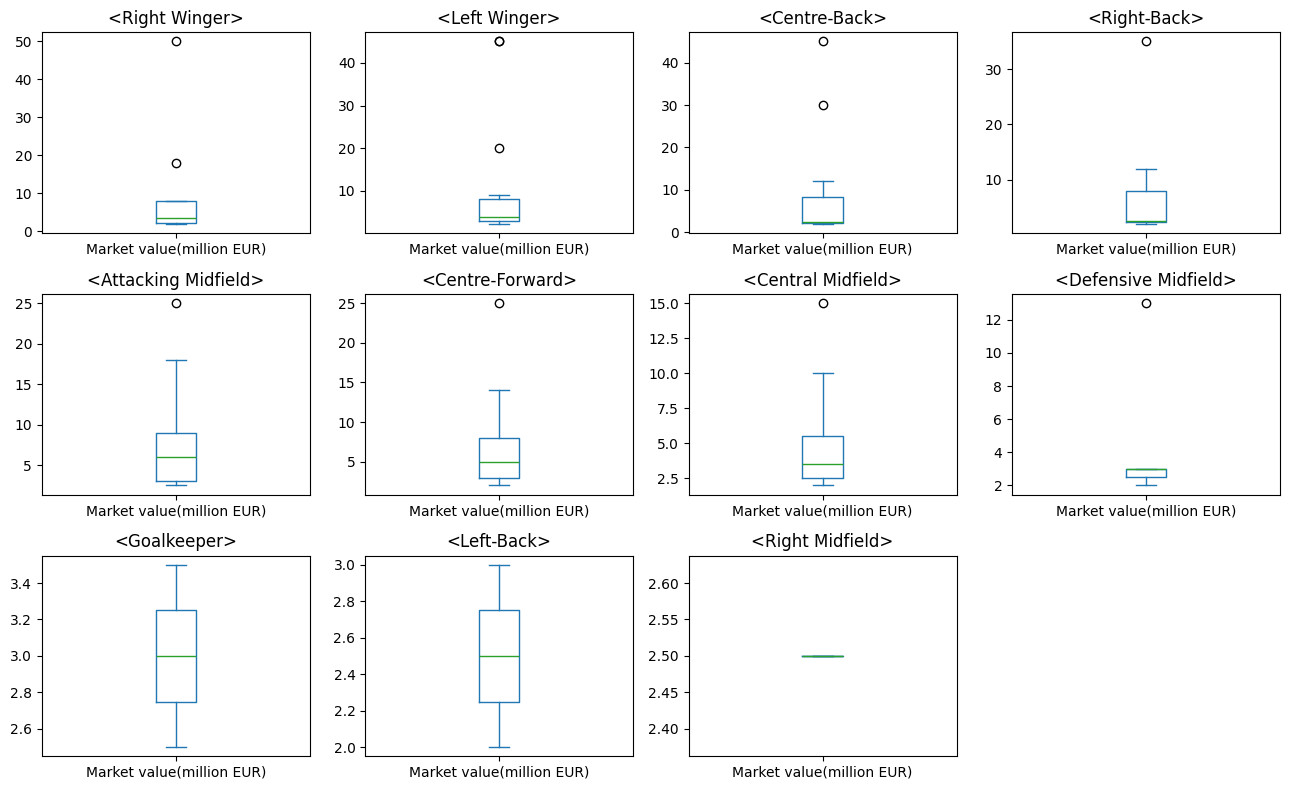

In [27]:
# 개별 포지션 별 선수 가치 분포
plt.figure(figsize=(13, 8))

positions = asia_players['position'].unique()

for i, position in enumerate(positions, 1):
    plt.subplot(3, 4, i)
    asia_players.loc[asia_players['position'] == position, 'Market value(million EUR)'].plot(kind='box') # 박스플롯
    # sns.violinplot(data=asia_players.loc[asia_players['position'] == position], x='Market value(million EUR)') # 바이올린 플롯
    plt.title(f'<{positions[i-1]}>')
plt.tight_layout()
plt.show()

## 나라별 선수 가치 평균, 합계 분포

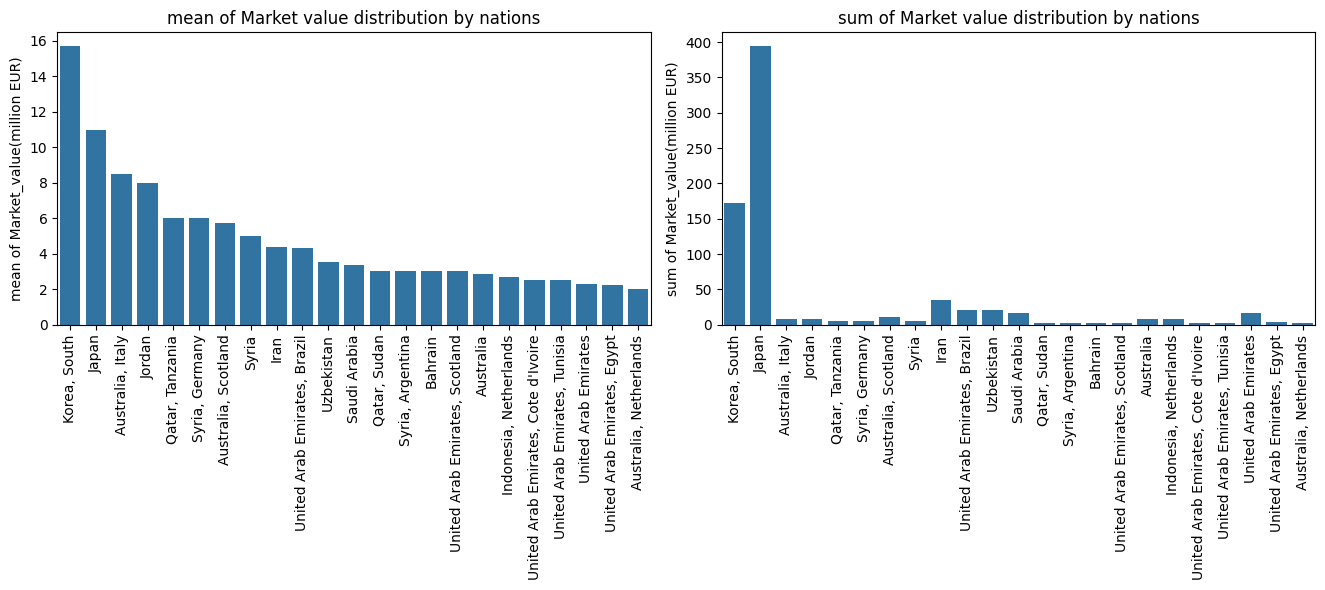

In [23]:
# 나라별 선수 가치 평균
mean_market_value_by_nation = asia_players.groupby('Nat.')['Market value(million EUR)'].mean().to_frame()\
                                          .rename(columns={0:'mean_market_value'}).reset_index().sort_values('Market value(million EUR)', ascending=False)

# 나라별 선수 가치 합계
sum_market_value_by_nation = asia_players.groupby('Nat.')['Market value(million EUR)'].sum().reset_index()

mean_sum_market_value_by_nation = mean_market_value_by_nation.merge(sum_market_value_by_nation, on='Nat.', how='left', suffixes=('_mean','_sum'))

titles= ['mean', 'sum']
cols = ['Market value(million EUR)_mean', 'Market value(million EUR)_sum']
plt.figure(figsize=(20, 6))
for i in range(1, 3):
    plt.subplot(1, 3, i)
    sns.barplot(data=mean_sum_market_value_by_nation, x='Nat.', y=cols[i-1], errorbar=None)
    plt.xlabel("")
    plt.ylabel(f"{titles[i-1]} of Market_value(million EUR)")
    plt.title(f"{titles[i-1]} of Market value distribution by nations")
    plt.xticks(rotation=90)
    
plt.tight_layout()
plt.show()

## 한국, 일본 집중 비교

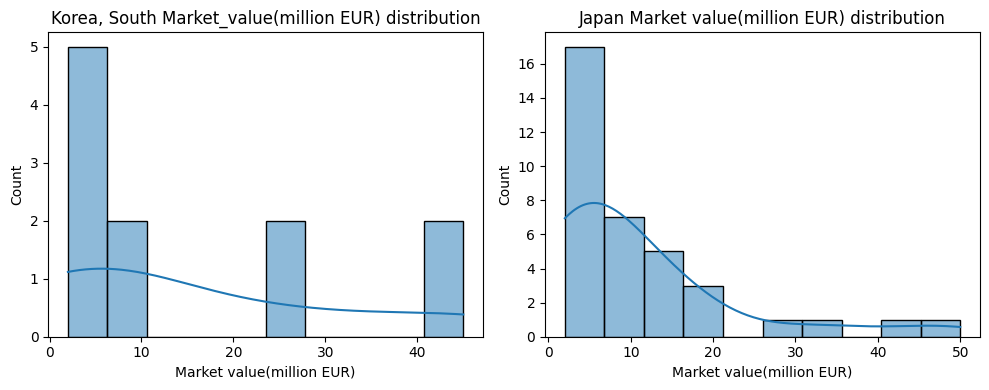

In [29]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(data=asia_players[asia_players['Nat.']=='Korea, South'], x='Market value(million EUR)', kde=True, bins=10)
plt.title('Korea, South Market_value(million EUR) distribution')

plt.subplot(1, 2, 2)
sns.histplot(data=asia_players[asia_players['Nat.']=='Japan'], x='Market value(million EUR)', kde=True, bins=10)
plt.title('Japan Market value(million EUR) distribution')

plt.tight_layout()
plt.show()

## 국가별 선수 count

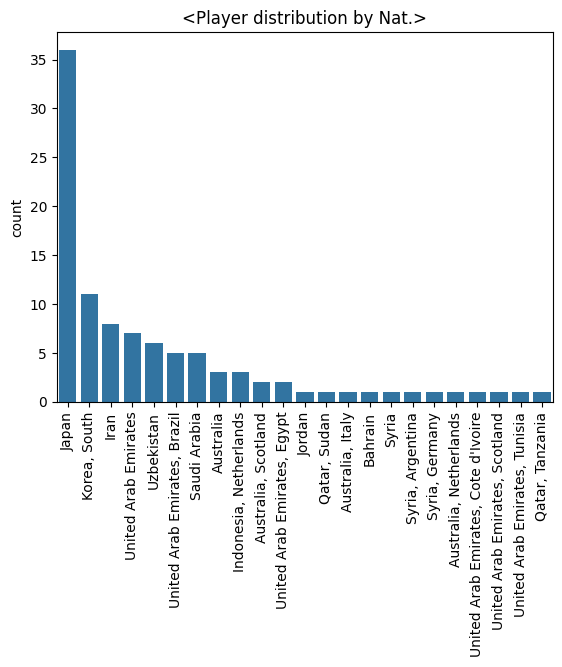

In [24]:
count_of_players_per_nation = asia_players.groupby('Nat.').size().sort_values(ascending=False).to_frame().rename(columns={0:'count'}).reset_index()
sns.barplot(data=count_of_players_per_nation, x='Nat.', y='count')
plt.title('<Player distribution by Nat.>')
plt.xticks(rotation=90)
plt.xlabel('')
plt.show()

## 클럽 별 선수 가치 분포

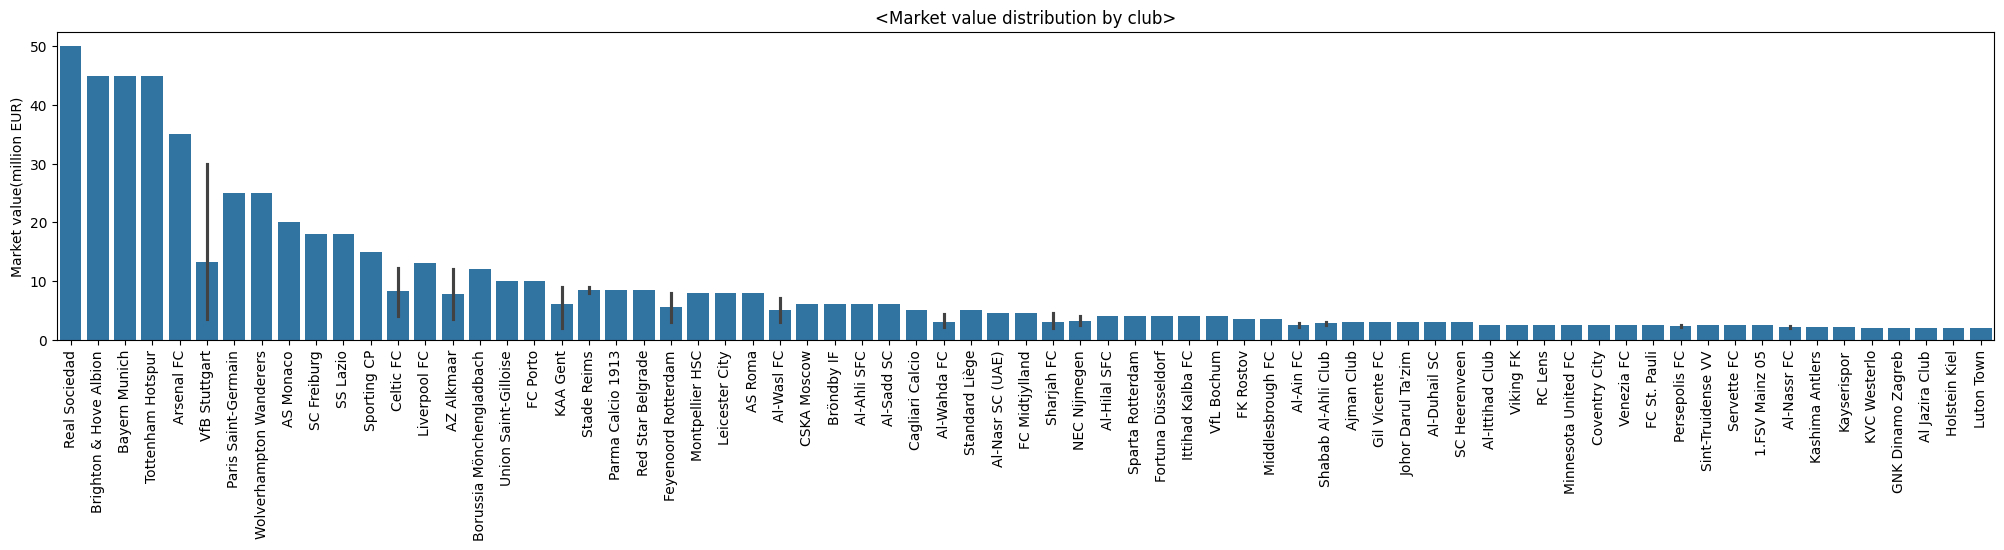

In [31]:
plt.figure(figsize=(25,4))
sns.barplot(data=asia_players, x='Club', y='Market value(million EUR)')
plt.xticks(rotation=90)
plt.title("<Market value distribution by club>")
plt.xlabel("")
plt.show() # 이미지 저장하려면 바탕화면에 드래그 아니면 쉬프트 누르고 좌클릭

## 나이별 선수 가치 분포

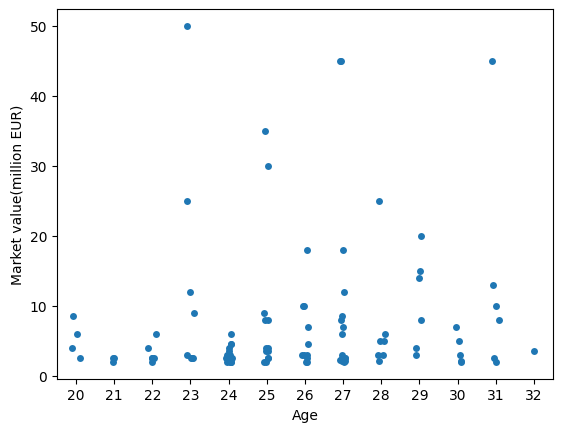

In [32]:
sns.stripplot(data=asia_players.sort_values('Age'), x='Age', y='Market value(million EUR)')
plt.show()

## 골수에 따른 선수 가치 분포

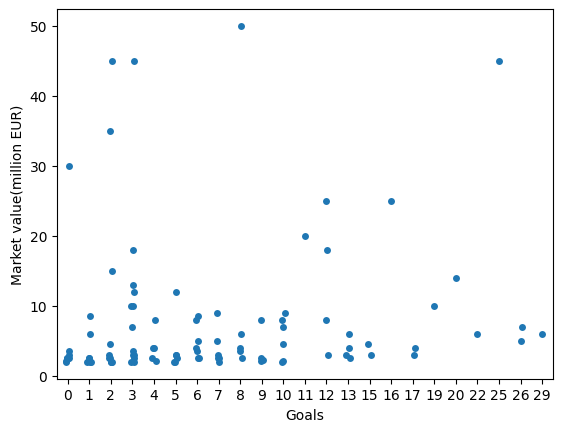

In [33]:
sns.stripplot(data=asia_players.sort_values('Goals'), x='Goals', y='Market value(million EUR)')
plt.show()

## 선수들은 한 경기당 골을 얼마나 넣을까

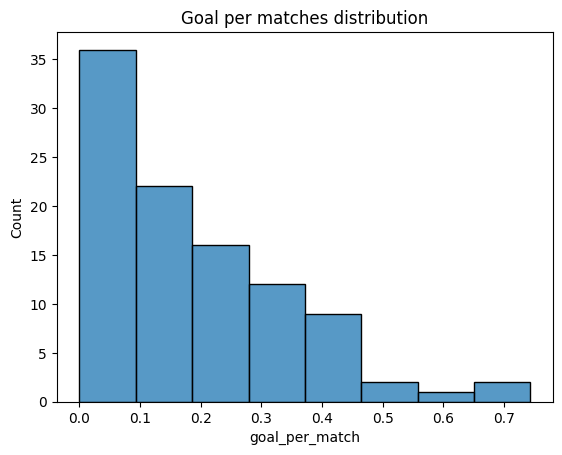

In [34]:
asia_players['goal_per_match'] = asia_players['Goals'] / asia_players['Matches']
sns.histplot(asia_players.sort_values('goal_per_match', ascending=False)[['player_name','goal_per_match']], x='goal_per_match')
plt.title('Goal per matches distribution')
plt.show()

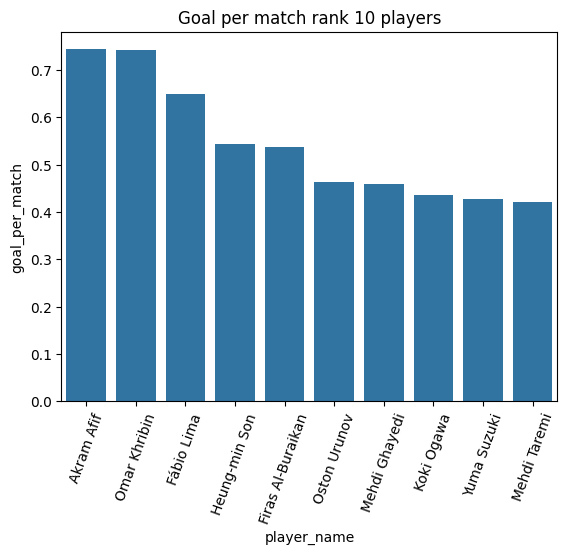

In [35]:
sns.barplot(asia_players.sort_values('goal_per_match', ascending=False)[['player_name','goal_per_match']].head(10), x='player_name', y='goal_per_match')
plt.title('Goal per match rank 10 players')
plt.xticks(rotation=70)
plt.show()

## 수치형 데이터와 선수가치의 상관관계 분석

In [36]:
asia_players.columns

Index(['Player', 'Age', 'Nat.', 'Club', 'Market value', 'Matches', 'Goals',
       'Own goals', 'Assists', 'Yellow cards', 'Second yellow card',
       'Red cards', 'Substitutions on', 'Substitutions off', 'player_name',
       'position', 'Market value(million EUR)', 'goal_per_match'],
      dtype='object')

In [37]:
for_corr = asia_players[asia_players.columns.difference(['Player', 'Nat.', 'Club', 'Market value', 'player_name', 'position', 'goal_per_match'])]

In [38]:
corr = for_corr.corr(numeric_only=True)
corr.style.background_gradient(cmap='summer')
# 딱히 선수가치과 관련있는 피쳐는 없어 보인다.
# 다만 경기 수와 골, 어시스트, 교체인, 교체아웃 등 경기와 관련된 것들은 당연하게 상관계수가 비교적 높다.

,Age,Assists,Goals,Market value(million EUR),Matches,Own goals,Red cards,Second yellow card,Substitutions off,Substitutions on,Yellow cards
Age,1.000000,0.132183,0.255190,0.134499,0.143677,-0.035889,0.109807,-0.143128,0.140809,-0.021112,0.029198
Assists,0.132183,1.000000,0.537834,0.156400,0.375219,-0.032986,0.104940,0.033892,0.435869,0.088668,-0.067702
Goals,0.255190,0.537834,1.000000,0.131726,0.253076,0.026149,0.034410,0.071951,0.417680,0.024355,-0.102842
Market value(million EUR),0.134499,0.156400,0.131726,1.000000,0.215946,0.025280,-0.104575,0.092750,0.106785,0.062706,-0.019157
Matches,0.143677,0.375219,0.253076,0.215946,1.000000,0.022709,-0.052323,0.110178,0.367792,0.175911,0.247421
Own goals,-0.035889,-0.032986,0.026149,0.025280,0.022709,1.000000,-0.071974,-0.063672,-0.052856,-0.044172,-0.134285
Red cards,0.109807,0.104940,0.034410,-0.104575,-0.052323,-0.071974,1.000000,0.024574,-0.080968,0.076813,-0.062549
Second yellow card,-0.143128,0.033892,0.071951,0.092750,0.110178,-0.063672,0.024574,1.000000,-0.195227,-0.010921,0.201969
Substitutions off,0.140809,0.435869,0.417680,0.106785,0.367792,-0.052856,-0.080968,-0.195227,1.000000,0.276310,-0.112068
Substitutions on,-0.021112,0.088668,0.024355,0.062706,0.175911,-0.044172,0.076813,-0.010921,0.276310,1.000000,-0.166169


In [39]:
corr['Market value(million EUR)']

Age                          0.134499
Assists                      0.156400
Goals                        0.131726
Market value(million EUR)    1.000000
Matches                      0.215946
Own goals                    0.025280
Red cards                   -0.104575
Second yellow card           0.092750
Substitutions off            0.106785
Substitutions on             0.062706
Yellow cards                -0.019157
Name: Market value(million EUR), dtype: float64

In [40]:
# 포지을 원-핫 인코딩한 후 상관관계를 살펴본다.
one_hot_encoding = pd.get_dummies(asia_players['position']).astype(int)
pd.concat([for_corr, one_hot_encoding], axis=1).corr().loc['Attacking Midfield':, 'Age':'Yellow cards'].style.background_gradient(cmap='summer')

,Age,Assists,Goals,Market value(million EUR),Matches,Own goals,Red cards,Second yellow card,Substitutions off,Substitutions on,Yellow cards
Attacking Midfield,-0.047023,0.258778,0.068536,0.027787,0.190893,-0.067904,-0.104828,0.036064,0.270963,0.316911,-0.028850
Central Midfield,0.054961,-0.032188,-0.123088,-0.115744,-0.146432,-0.090705,-0.046676,-0.123876,0.069875,0.057621,-0.042041
Centre-Back,-0.143030,-0.466431,-0.317226,0.028054,-0.124184,0.139703,-0.069411,0.149673,-0.551575,-0.363313,0.210999
Centre-Forward,0.123663,0.072773,0.463879,-0.028475,0.020742,-0.004319,-0.046676,-0.020646,0.191880,0.172864,-0.084083
Defensive Midfield,0.131853,-0.139863,-0.170085,-0.067361,-0.076588,-0.049536,0.076472,0.101477,-0.022412,-0.041538,0.206636
Goalkeeper,0.037047,-0.179897,-0.155069,-0.066358,0.092856,-0.030846,-0.047619,-0.042126,-0.228949,-0.166951,-0.150117
Left Winger,-0.102071,0.275697,0.328088,0.130862,-0.013312,-0.004319,0.140028,-0.020646,0.162303,-0.016134,-0.063062
Left-Back,-0.129014,0.027536,-0.117545,-0.090528,0.020348,-0.037973,-0.058621,-0.051859,-0.119332,-0.128331,0.101200
Right Midfield,0.043674,-0.076339,0.000943,-0.051736,-0.051328,-0.021701,-0.033501,-0.029637,-0.041661,0.031431,-0.030175
Right Winger,0.098125,0.063297,-0.017726,0.079713,0.028741,-0.071974,-0.000000,-0.098295,0.235864,0.098760,-0.125098
